## Motivation



<!---

What is your dataset?

Why did you choose this/these particular dataset(s)?

What was your goal for the end user's experience?

-->

Our project focuses on studying global life expectancy, with a specific emphasis on Japan. To explore and explain life expectancy from various angles, we have utilized multiple data sources. We chose this topic because it lends itself well to comprehensive analysis and greatly interests many people. Understanding which factors contribute to a longer life is a common curiosity individuals share worldwide. In addition, the topic is broad and offers a temporal element (the development through time) that could be explored and explained through visual representations. Using a statistical approach and examining data across time and space, we could create engaging visualizations that enhance the storytelling aspect of our project.

Our goal was to examine both the economic, social and lifestyle factors that influence life expectancy and also to give the reader an idea of the development of life expectancy globally. To achieve this, we gathered data from sources such as the World Bank, the World Health Organization (WHO), the United Nations, OECD, the human mortality database, and various other independent sources, including Wikipedia. The World Bank provided population data, GDP, and health expenditure information for different countries over the years. WHO data includes life expectancy and cause of death statistics across countries and years. The United Nations was used to find data on countries' diets and meat consumption, while OECD data provided insights into daily activities based on nationality. So we had data both to cover a broad range of factors that influence life expectancy, and also to provide a historical perspective on the development of life expectancy globally.

Our article aimed to create an informative and captivating reading experience. We wanted to combinate much relevant information into one story, such that the reader would be able to both learn something about history and also be able to reflect on their own life and how they can improve their chances of living a long life. Our primary focus was to make the article accessible and understandable to a broad audience, combining readability with engaging visuals to provide an enjoyable reading experience.

### imports

In [1]:
# These are the all the dependencies used in the notebook

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from folium import plugins

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange, Legend, Range1d, Panel, Tabs # (requires bokeh<2.3.3>) (pip install bokeh==2.3.3)
from bokeh.plotting import figure

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import os
import calplot
import json
from urllib.request import urlopen

## Basic stats


<!---

Let's understand the dataset better

Write about your choices in data cleaning and preprocessing

Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

-->

We go through each dataset one by one:

1. [The WHO data on life expectancy for countries over time](https://www.kaggle.com/datasets/ulrikthygepedersen/life-expectancy?fbclid=IwAR0JO7W1_G3prS0O48OITDxvSeQPm64MtaUOIbfNjBCzcHttAUh_tC3xJME)

This dataset is clean from the beginning and consists of 4 columns. The first column is a short-hand code for the country's name; the second column is the country's name, the third column is the year, and the fourth column is the life expectancy.

The data has no missing values and is easy to use. We use this data to plot the development of life expectancy over time for different countries on a global map.

2. [The World Bank data](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?fbclid=IwAR2Jf_Asqt1WWMuQ_S1bobud8Q36WcVEYDx4lF0RrdCprmiESBD0yyNaGDk)

These are the GDP and Health datasets. For both datasets, we did the same preprocessing. The data contains values for years and countries about GDP or health expenditure in dollars per capita.
This data is less clean. There are a lot of NaN values which we have excluded. We preprocess this dataset by combining it with the WHO dataset to get a new dataset with 4 columns, year, country,life expectancy and GDP/Health expenditure.

3. [The UN data](https://www.populationpyramid.net/)

This data is what is used to make the population pyramid plots. Each CSV file we got from here represents one country in one year. The data simply consists of 3 columns, age group, amount males and amount females. The only preprocessing that was necessary here was to combine the number of males and females into 1 column, as we decided not to focus on the difference between male and female in this scope.

4. [the OECD data](https://ourworldindata.org/time-use)

This data is used to plot the time spent on daily activities. The data is clean from the beginning and consists of 3 columns, country, activity, and percentage of people doing the activity.

5. [WHO data on obesity rate, daily caloric intake, prevalence of insufficient physical activity and suicide rate](https://apps.who.int/gho/data/node.main)

For these 4 indicators, we used the most recently available data. For obesity and suicice rates this meant data from year 2016, whereas data from 2019 and 2018 was downloaded for prevalence of insufficient physical activity among adults and daily caloric supply, respectively. These data came clean without NaNs and, thus, did not require further preprocessing. The data files simply include two columns; a country column and the value of the indicator.

6. [Cause-specific mortality rates for Germany, Italy, US and Japan data from WHO](https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates/ghe-leading-causes-of-death)

This data comes clean without NaNs in Excel files for the individual countries. We only kept the 90th percentile of data for each country to visualize that information as the top 10% most common death causes.

7. [Meat consumption data from UN FAO - downloaded from OurWorldinData](https://ourworldindata.org/meat-production)

This data originates from the Food and Agriculture Organization of the United Nations and was obtained via OurWorldinData. The data is clean and did not require further preprocessing before visualization.

8. [The Human Mortality Database](https://www.lifetable.de/)

This website is comprehensive but also by far the messiest to make good use of. Here we obtain the life tabless data tables that can be used to calculate life expectancy and conditioned life expectancy (e.g., given you are this old, how long can you expect to live). This data is used in the "chance of surviving to this age" plot and the plot with the oldest human. For each country, they found sources covering intervals in years that you can check up on. So, for example, some sources may contain data from only every 5 years in some intervals, while other intervals every year, and some years no data at all. In addition, it is very rare for less developed countries to have any sources that go further back in time than the year 2000. The preprocessing consisted of finding a reliable source for each country and year intervals and hopefully finding enough to more or less cover the entire span of 1960 to 2020. (else we simply did linear interpolation between the years we know). The dataset also comes with many other features that had to be sorted out and were separated into male and female, which we simply combined into one category. To give an idea of the chaos of the data, the code for producing the "change of surviving to this age" is listed below. (note we could not just do a general loop for each country and year, as the features vary from dataset to dataset)




### Code

In [2]:
# countries: 'Japan', 'Denmark', 'Deutchland', 'Brazil', 'USA', 'Sweden', 'Bolivia', 'South_Africa'

# make dict with countries and years
all_data = dict()

country = "Japan"
# Make plot for Japan 1960
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Japan 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

country = "Denmark"
# Make plot for Denmark 1960
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == 1961]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Denmark 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of Denmark 1901
year = 1901
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df



country = "Deutchland"
# Make plot for Deutchland 1960
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Deutchland 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Brazil 1960
country = "Brazil"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df


# Make plot for Brazil 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for USA 1960
country = "USA"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for USA 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Sweden 1960
country = "Sweden"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Sweden 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of Sweden 1751
year = 1751
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df
# Make plot for South Africa 1960
country = "South_Africa"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for South Africa 2006
year = 2006
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of India 1961
country = "India"
year = 1961
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['TypeLT'] == 1]
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of India 2014
year = 2014
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# For each country, divide by the first value to get a percentage
for key, val in all_data.items():
     divisor = val.head(1).values[0][0]
     for i in range(len(val)):
          val.iloc[i] = val.iloc[i] / divisor * 100
fig = go.Figure()

colors = ['firebrick', 'royalblue', 'green', 'orange', 'purple', 'red', 'black', 'deepskyblue']
styles = ['solid', 'dash', 'dot', 'dashdot']

# For each country, make a plot
for i, country in enumerate(['Japan', 'Denmark', 'Deutchland', 'Brazil', 'USA', 'Sweden', 'South_Africa', 'India']):
     for j, year in enumerate([2019, 2014, 2006, 1961, 1960, 1901, 1751]):
          if year > 2000:
               j = 0
          elif year < 2000 and year > 1950:
               j = 1
          else:
               j = 2

          if (country, year) in all_data:
               vis = 'legendonly'
               if country in ['India', 'Japan']:
                    vis = None
               fig.add_trace(go.Scatter(x=list(all_data[(country, year)].index.values), y=all_data[(country, year)].to_numpy()[:,0].tolist(), name=str(country + ' ' + str(year)).replace('_', ' '),
                                        line=dict(color=colors[i], width=2, dash=styles[j]), opacity=1, mode='lines', visible=vis, showlegend=True))

# Edit the layout
fig.update_layout(title='Chance of surviving till age for various countries and times',
                   xaxis_title='Age (years)',
                   yaxis_title='Chance of surviving to this age (%)',
                   yaxis_range=[0,100],
                   xaxis_range=[0,100])

fig.show()
fig.write_html("Survival_rate.html")

C:\Users\jakob\AppData\Local\Temp\ipykernel_12704\2880115058.py:63: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('life_tables/' + country + '.csv')
C:\Users\jakob\AppData\Local\Temp\ipykernel_12704\2880115058.py:73: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('life_tables/' + country + '.csv')
C:\Users\jakob\AppData\Local\Temp\ipykernel_12704\2880115058.py:105: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('life_tables/' + country + '.csv')
C:\Users\jakob\AppData\Local\Temp\ipykernel_12704\2880115058.py:115: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('life_tables/' + country + '.csv')


## Data Analysis


<!---
Describe your data analysis and explain what you've learned about the dataset.

If relevant, talk about your machine-learning.
-->

From the beginning, we knew we wanted a world map of life-expectancy development for all countries. This would, for the reader, serve as an eye-catcher and an excellent broad way to start the article, while for us, the writers, provide a high-level idea of exciting things to investigate further on. As a matter of fact, we needed to figure out how to focus on Japan before this point even. Then we saw how the life expectancy in Japan actually seemed quite outlying and decided to focus on it. Some interesting observations from this exploratory phase were how life expectancy had improved dramatically in China and, in general, how the world has become more equal in terms of life expectancy, as particularly Africa has a much higher life expectancy now than in 1960.

To make it easier to understand how much these countries have changed, we also made an interactive barplot that compares their life-expectancy from 1960 to 2020. Having a barplot like this makes comparison easier than having to look at the whole world map, which, however, provides for a more holistic and aesthetic experience.

After that, we decided to look more into the distribution of how long people live rather than just having the life expectancy. This gave rise to the "chance of surviving to this age" plot. From this plot, we learned that there are specific characteristics that differentiate the developing countries from the developed countries. Notably, the high mortality rate was apparent from this plot. Moreover, the death rate is closer to linear in developing countries, while in developed countries, it is first flat (almost no one dies before age 50) and then starts to fall.

This discrepancy, we thought, would give rise to different population pyramid structures. So we decided to look into that. Here we also saw a difference, which we made an interactive plot in order for us and the reader to explore.


Furthermore, we wanted to know and show if there is a connection between GDP, Health Expenditure and life expectancy. To do this, we plotted GDP and Health Expenditure against life expectancy for different years. We intuitively understood there was a connection from looking at the scatter plot, but it did not show a linear trend. So we transformed the x-axis into log-space (semi-log plot), and here we saw quite the appropriate fit. So we fitted a linear function in this semilog-space and got a pretty nice fit from eye-balling the plot. 

Ultimately, we decided to transform the data (and regression line) back into a regular (not logarithmic) plot. We thought it looked better and was perhaps easier to grasp for the non-scientific reader. Indeed, we also did this same plot for different years than 2019, but we decided only to include the plot for 2019 on the website, as it alone conveyed the message we were interested in. Including the data from years other than 2019 makes the plot messier and harder to read, and the message is mostly the same. 

One interesting point we saw when looking at the plots from 1960 and 1990 instead of only 2019 is that the logistic regression slope was higher back then. In other words, the GDP and Health Expenditure were predicted to continue to improve life-expectancy without flattening out after awhile. This is probably due to the fact that the life expectancy was much lower back then, and the effect of GDP and Health Expenditure is more prominent when the life expectancy is lower. In addition, some countries now have an incredibly high GDP, but it does not represent the actual 'richness' of the country because companies use these countries as tax havens. Furthermore, GDP usually only considers citizens of the country, so countries where many people work in other countries, but send money back to their home country, will have a lower GDP than they should have. Thus whether this observation is meaningful or whether it is just a result of GDP not being a perfect measure of wealth is hard to say. Indeed for Health Expenditure, we saw how the USA spends a lot even with a relatively low life expectancy. This led us to the conclusion that not only do you have to spend many resources, but you also have to spend them in the right way.

 The code for these plots is below.

### Code

**Health expenditure Vs. Life Expectancy**

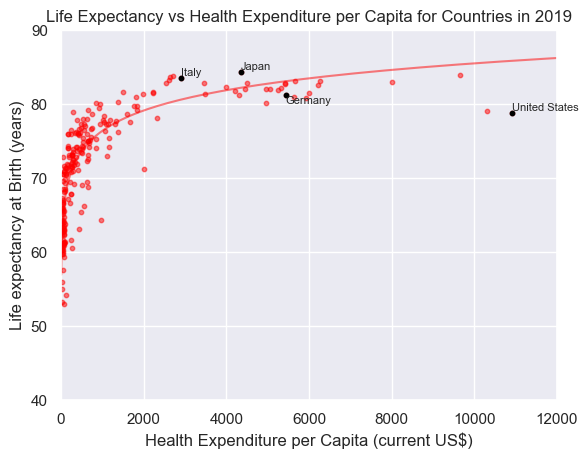

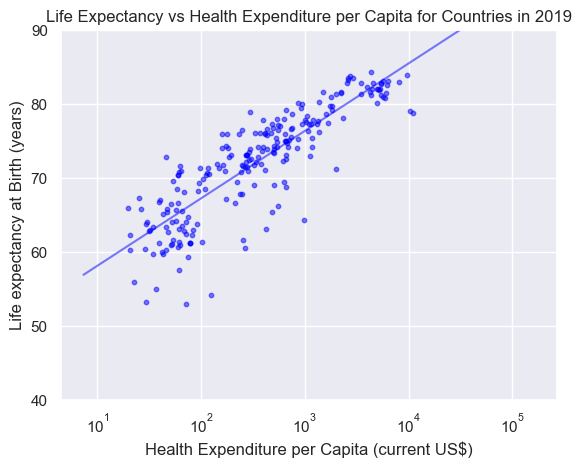

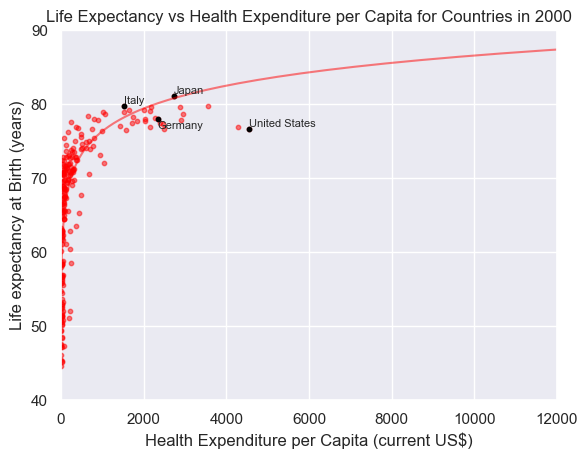

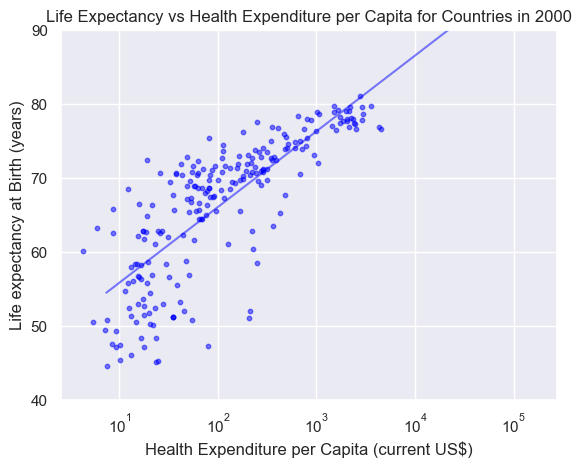

In [34]:
sns.set_theme()

# Life expectancy data
life_expectancy = pd.read_csv('data/API_SP.DYN.LE00.IN_DS2_en_csv_v2_5358385.csv', skiprows=4)

# Health expenditure data
health_expenditure = pd.read_csv('data/API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_5359940.csv', skiprows=4)

years = ['2019', '2000']
for year in years:
    # Only keep columns for life_ex: Country Name, 2019
    # make a copy of life_Expectancy dataframe
    life_ex = life_expectancy.copy()
    life_ex = life_ex[['Country Name', year]].copy()
    # Only keep columns for life_ex: Country Name, 2019
    health_ex = health_expenditure.copy()

    health_ex = health_ex[['Country Name', year]]

    # add new column in health_ex with life expectancy
    health_ex['Life Expectancy at Birth (total years)'] = life_ex[year]

    # rename 2019 column to Health Expenditure per Capita (current US$)
    health_ex.rename(columns={year: 'Health Expenditure per Capita (current US$)'}, inplace=True)

    # Drop nans
    health_ex.dropna(inplace=True)


    # Sort by Health Expenditure per Capita (current US$)
    health_ex.sort_values(by='Health Expenditure per Capita (current US$)', ascending = False, inplace=True)


    # Reset index
    health_ex.reset_index(drop=True, inplace=True)

    # Conditional plot for the year 2020
    df_2020 = health_ex

    # print(df_2020.shape)

    plt.scatter(data=df_2020, x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='red', marker='o', s=10, alpha=0.5, label=year)

    # Fit a linear model between log health expenditure and life expectancy
    reg = LinearRegression().fit(np.log(df_2020['Health Expenditure per Capita (current US$)']).values.reshape(-1, 1), df_2020['Life Expectancy at Birth (total years)'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=2, stop=12, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]

    # Use a red color to symbolize health expenditure
    plt.plot(np.exp(x), y, alpha=0.5, c='red')

    # Annotate Japan with country name, make point bigger
    for row in df_2020.index:
        if df_2020.loc[row, 'Country Name'] in ['Japan', 'Germany', 'Italy', 'United States']:
            plt.scatter(data=df_2020.loc[row, :], x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='black', marker='o', s=10, alpha=1)
            plt.text(x=df_2020.loc[row, 'Health Expenditure per Capita (current US$)'] + 0.2, y=df_2020.loc[row, 'Life Expectancy at Birth (total years)'] + 0.3 - 1.6*(df_2020.loc[row, 'Country Name'] == 'Germany'), s=df_2020.loc[row, 'Country Name'], fontsize=8)

    plt.title('Life Expectancy vs Health Expenditure per Capita for Countries in' + ' ' + year)

    # make y axis go from 0 to 100
    plt.ylim(40, 90)
    plt.xlim(0, 12000)
    plt.xlabel('Health Expenditure per Capita (current US$)')
    plt.ylabel('Life expectancy at Birth (years)')
    plt.show()

    plt.scatter(data=df_2020, x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='blue', marker='o', s=10, alpha=0.5, label=year)
    plt.plot(np.exp(x), y, alpha=0.5, c='blue')
    plt.title('Life Expectancy vs Health Expenditure per Capita for Countries in' + ' ' + year)
    # make xaxis log scale
    plt.xscale('log')
    # make y axis go from 0 to 100
    plt.ylim(40, 90)
    plt.xlabel('Health Expenditure per Capita (current US$)')
    plt.ylabel('Life expectancy at Birth (years)')
    plt.show()




**GDP Vs. Life Expectancy**

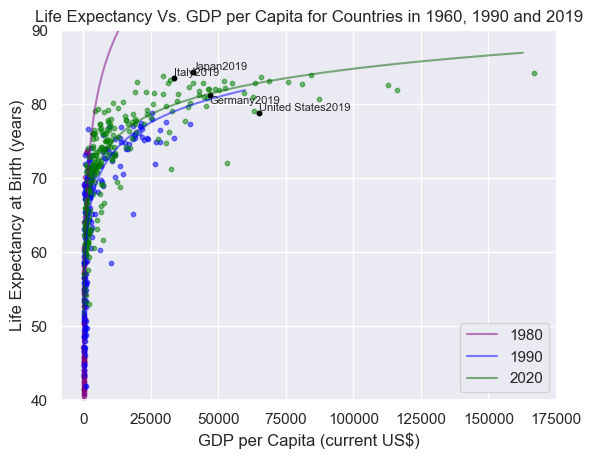

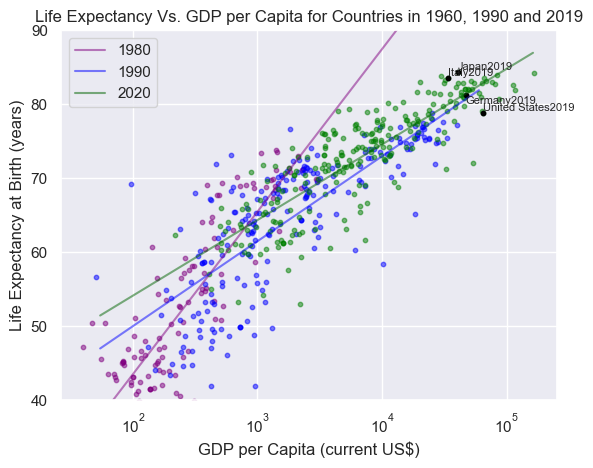

In [44]:
sns.set_theme()

for semilog in [False, True]:
    # Read in the data for GDP
    df_GDP = pd.read_csv('GDP_data/data.csv')

    # Read in the data for life expectancy
    df = pd.read_csv('life_expectancy_by_country.csv')
    df['GDP'] = np.nan

    # Loop over rows in df
    for row in df.index:
        # Get the country name
        country = df.loc[row, 'country_name']
        # Get the year of the row
        year = df.loc[row, 'year']
        # Get the GDP value for the country
        GDP = df_GDP.loc[df_GDP['Country Name'] == country, str(year)].values[0]
        # Set the GDP value in df
        df.loc[row, 'GDP'] = GDP

    # Only keep data from 1980, 1990 and 2020
    df = df.loc[df['year'].isin([1960, 1990, 2019]), :]

    # Remove Hong Kong and Macao from data
    df = df.loc[~df['country_name'].isin(['Hong Kong SAR, China', 'Macao SAR, China']), :]

    # Remove rows with any nan values from data
    df = df.loc[~df.isna().any(axis=1), :]

    # Conditional plot for the year 1980
    df_1980 = df.loc[df['year'] == 1960, :]
    plt.scatter(data=df_1980, x='GDP', y='value', c='purple', marker='o', s=10, alpha=0.5, label='_nolegend_')

    # Fit a linear model between log GDP and life expectancy
    reg = LinearRegression().fit(np.log(df_1980['GDP']).values.reshape(-1, 1), df_1980['value'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=4, stop=11, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]
    plt.plot(np.exp(x), y, alpha=0.5, c='purple', label='1980')

    # Conditional plot for the year 1990
    df_1990 = df.loc[df['year'] == 1990, :]
    plt.scatter(data=df_1990, x='GDP', y='value', c='blue', marker='o', s=10, alpha=0.5, label='_nolegend_')

    # Fit a linear model between log GDP and life expectancy
    reg = LinearRegression().fit(np.log(df_1990['GDP']).values.reshape(-1, 1), df_1990['value'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=4, stop=11, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]
    plt.plot(np.exp(x), y, alpha=0.5, c='blue', label='1990')


    # Conditional plot for the year 2020
    df_2020 = df.loc[df['year'] == 2019, :]
    plt.scatter(data=df_2020, x='GDP', y='value', c='green', marker='o', s=10, alpha=0.5, label='_nolegend_')

    # Fit a linear model between log GDP and life expectancy
    reg = LinearRegression().fit(np.log(df_2020['GDP']).values.reshape(-1, 1), df_2020['value'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=4, stop=12, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]
    plt.plot(np.exp(x), y, alpha=0.5, c='darkgreen', label='2020')
    plt.legend()

    # Annotate Japan with country name, make point bigger
    df = df.loc[df['year'].isin([2019]), :]
    for row in df.index:
        if df.loc[row, 'country_name'] in ['Japan', 'Germany', 'Italy', 'United States']:
            plt.scatter(data=df.loc[row, :], x='GDP', y='value', c='black', marker='o', s=10, alpha=1)
            plt.text(x=df.loc[row, 'GDP'] + 0.2, y=df.loc[row, 'value'] + 0.3 - 1.6*(df.loc[row, 'country_name'] == 'Germany'), s=df.loc[row, 'country_name'] + str(2019), fontsize=8)

    plt.title('Life Expectancy Vs. GDP per Capita for Countries in 1960, 1990 and 2019')

    # Make y axis go from 0 to 100
    plt.ylim(40, 90)
    plt.xlabel('GDP per Capita (current US$)')
    plt.ylabel('Life Expectancy at Birth (years)')
    # make xaxis log scale
    if semilog:
        plt.xscale('log')
    plt.show()


## Genre

<!---
Which genre of data story did you use?

Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
-->

**Genre** <br>
To tell the data story of global life expectancy, we chose to follow a **magazine style** narrative genre. The reasoning behind this choice is to provide broad appeal, both visually and content-wise while delivering an informative reading experience. The reader is presented with an article that flows naturally with easily understandable language but also includes rich data visualizations that support the narrative.

**Visual Narrative Tools from Segal and Heer** <br>
For visual structuring, we aim to provide our readers a **Consistent Visual Platform**. This is seen in the visualizations where we use similar color themes for plots that are within the same category in terms of content and interactivity. Moreover, all the content is on a single page. All that the user needs to do is to scroll down, a gesture that is familiar to most readers and is, thus, in line with our goal of having a broad appeal while providing narrative continuity. There is no need to switch pages. All you do is simply scroll. For the interactive visualizations, readers can get **close-ups** of the data, navigate the **distinctive features**, and **zooming** in on the ones that they find most interesting. In the very beginning, we have chosen to include a large map of life expectancy over time across the world. The idea was to provide a visually catchy introduction to capture and retain the reader's attention from the very beginning of the narrative. This map provides **animated transitions** through time in **motion** for life expectancy, over time, for the entire world and provides an excellent overview of the temporal aspect in an aesthetically pleasing and informative manner.

**Narrative Structure Tools from Segal and Heer** <br>
While the ordering of our article is thought to be **linear**, certain sections are still readable independently from each other. This is due to certain choices we have made with narrative structuring. Generally, the article can be divided into 4 main parts with the appropriate **Captions / Headlines**. First, it begins with an **Introductory Text** that introduces the main topics and questions that the article will explore. Second, we cover global life expectancy. Third, we zoom in on Japan for the narrative focus. And finally, we provide a **Summary** of the answers that were found. The aforementioned sections can be read independently from each other in terms of ordering, despite the intention being from top to bottom in a linear way. Throughout the article, we include sources along with the **Accompanying Articles** for everything that is written and annotations on plots so they are made even more intuitive. The interactive plots all have **Stimulating Default Views**, where the reader can **Hover** over the data and get an extra layer of information while also being able to **Highlight/filter** the shown data for the bar charts, specifically. We also include visualizations with **Very Limited Interactivity**.


**Narrative Reflections**
While the narrative mainly remains author-driven, we introduce reader-driven elements through interactive visualizations. Consequently, our data story does have elements from the **Interactive Slideshow structure** since free interactivity is incorporated mid-narrative within the confines of the respective sections. Hence, readers can explore specific aspects of the content/data before moving on to the next part of the story when they are ready to do so. The individual slides would, in our case, be the sections that follow the **Martini Glass structure**, where the author-intended messaging is communicated before the user is presented with the option to explore interactively.

## Visualizations

Explain the visualizations you've chosen.

Why are they right for the story you want to tell?

## Discussion

<!---
Think critically about your creation

What went well?

What is still missing? What could be improved?, Why?
-->

Overall we managed to take our readers on a journey that explored life expectancy globally, specifically focusing on Japan. Our article came full circle as we delved into the intriguing concept of human immortality. Additionally, we enhanced the narrative through visually appealing and relevant visualizations. Which, when we realized we ourselves would sit and spend a lot of time playing with, turned out to go great. We were thrilled to discover that our data exploration led us to uncover new ideas and relevant datasets, transforming our investigation into an exciting adventure. This journey allowed us to authentically experience and convey the story behind the data.

We could have delivered more specific advice to people about how to live longer. We mainly looked at cultural differences and found upsides and downsides, but didn't really say much about what you can do to balance these risks and live a longer life. We approached the question more from a statistical perspective rather than focusing extensively on interventions or practical recommendations for our readers seeking guidance, which could have been beneficial. This was maybe a little bit of a result from deciding to "squeeze" the story of Japan in the article, rather than just staying at life-expectancy as a whole, which would have given more space for this. 

Furthermore, we could have included more data on the risks associated with specific factors that contribute to a shorter lifespan. For instance, exploring the likelihood of developing certain diseases due to inadequate sleep would have added valuable insights. Rather than merely referring to existing studies, it would have been preferable to find our own dataset on this subject to explore and explain. This would have given more visual support to our narrative, and would have kept us in the realm of keeping the reader engaged with the data.

Although we acknowledged several factors that were beyond the scope of our project, expanding our research to include them would have yielded valuable findings. Topics such as smoking, alcohol consumption, and other lifestyle choices could have been explored further. These factors are known to have a significant impact on life expectancy, and many readers would probably have been interested in learning more about them.

In addition, it would have been valuable to explore the influence of social connections and the significance of leading a meaningful life on life expectancy. We mention some research done on this, but again, it would be better to have some data on it to explore.

Furthermore, investigating the impact of religion and individual perspectives (such as optimism vs pessimism, and living for oneself vs for others) on longevity could have provided intriguing insights. Although obtaining data on these aspects is hard, these topics deserve more attention in the future.

The visualizations and structure of the article was executed well. The initial global map effectively captures readers' attention, setting a broad context that aligns with the article's purpose. However, we may have dedicated a bit too much time to this section, as the next 2 or 3 plots still explores life-expectancy on a high-level globally, which gives less time to dig into the individual factors. In additional, we repeat some of the information provided sometimes framed differently (as a result of having plots which display some of the same information), which could potentially have been avoided.
Nevertheless, the plots themselves are engaging and visually appealing, successfully conveying the intended message. We managed to incorporate them effectively into the article. Overall, we are satisfied with the outcome, as the plots fulfill their purpose and contribute positively to the overall narrative.



## Contributions

<!---
Who did what?

You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).

It is not OK simply to write "All group members contributed equally".

Make sure that you use references when they're needed and follow academic standards.
Handing in the assignment: Simply upload the link to your website to peergrade.
-->

We had weekly discussions about where to take the project. 

David was the main guy for the world map, and was the main guy in the exploratory part with plotting and finding data for the GNP, Health Expenditure and gini index (which we ended up not including). In addition, he was the main guy for the top 10 causes of death plot.

Huayuan was the main guy in terms of making all the interactive Bokeh plots, in addition he was the main guy in terms of making the plots and finding data for the meat consumption, time spent on activities, and the bar chart for some factors seperating the countries.

Jakob was the main guy in terms making the "oldest human alive" plot, as well as the Health expenditure vs GDP with logaritmic regression. He also was the main guy for "chance of surviving to this age" interactive plot.

All choices has been made in discussion and everyone has helped each other out with the code. Data investigation was done by all of us.  Huayuan and Jakob were main guys for writing the article and making the notebook by combining all the code.